# Quantify Flakes

One of the key perfomance indicators that we would like to create greater visbility into and track over time is overall number and percent of flakes that occur. Individual test runs are flagged a "flake" if they are run mulitple times with a mix of passes and failes without any changes to the code being tested. Although they occur for individual test runs, there are a number of aggregate views that developers may want to look at to assess the overall health of thier project or testing platform. For Example:

* percent flakes on platform each day
* percent flakes by tab each week
* percent flakes by grid each month
* percent flakes by test overall (this can also be seen as a severity level = overall flake rate of test)

In order to provide maxium flexibility for the end-user of this work, instead of creating a number of dataframes to answer each of these specifc questions, we will define a long and narrow data structure (a list of tuples saved as a csv for now) that contains only 5 columns ("timestamp", "tab","grid","test","flake"). This allows superset (or pandas) to perform the last filter and/or aggreagtion of interest to an end user. Which is to say, there may appear to be a lot of repetion within the final dataset, but each row should be unique, and it should provide the simpelest useability for an end-user.    


In [1]:
import gzip
import json
import os
import sys
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
sys.path.append("../../..")

module_path_1 = os.path.abspath(os.path.join("../../../data-sources/TestGrid"))
if module_path_1 not in sys.path:
    sys.path.append(module_path_1)

from ipynb.fs.defs.testgrid_EDA import decode_run_length  # noqa: E402

In [2]:
# Load test file
with gzip.open("../../../../data/raw/testgrid_810.json.gz", "rb") as read_file:
    testgrid_data = json.load(read_file)

In [3]:
def testgrid_labelwise_encoding(data, label):

    """
    Run length encode the dataset and unroll the dataset into a list.
    Return flattened list after encoding specified value as
    True and rest as False
    """

    percent_label_by_grid_csv = []

    for tab in data.keys():

        for grid in data[tab].keys():
            current_grid = data[tab][grid]
            if len(current_grid["grid"]) == 0:
                pass
            else:
                # get all timestamps for this grid (x-axis of grid)
                timestamps = [
                    datetime.datetime.fromtimestamp(x // 1000)
                    for x in current_grid["timestamps"]
                ]
                # get all test names for this grid (y-axis of grid)
                tests = [
                    current_grid["grid"][i]["name"]
                    for i in range(len(current_grid["grid"]))
                ]
                # unroll the run-length encoding and set bool for flake or not (x==13)
                decoded = [
                    (
                        np.array(decode_run_length(current_grid["grid"][i]["statuses"]))
                        == label
                    ).tolist()
                    for i in range(len(current_grid["grid"]))
                ]
                # add the timestamp to bool value
                decoded = [list(zip(timestamps, g)) for g in decoded]
                # add the test, tab and grid name to each entry
                # TODO: any ideas for avoiding this quad-loop
                for i, d in enumerate(decoded):
                    for j, k in enumerate(d):
                        decoded[i][j] = (k[0], tab, grid, tests[i], k[1])
                # accumulate the results
                percent_label_by_grid_csv.append(decoded)

    # output above leaves us with a doubly nested list. Flatten
    flat_list = [item for sublist in percent_label_by_grid_csv for item in sublist]
    flatter_list = [item for sublist in flat_list for item in sublist]

    return flatter_list

In [4]:
unrolled_list = testgrid_labelwise_encoding(testgrid_data, 13)

In [5]:
unrolled_list[0]

(datetime.datetime(2020, 10, 8, 16, 48, 5),
 '"redhat-openshift-informing"',
 'release-openshift-okd-installer-e2e-aws-upgrade',
 'Application behind service load balancer with PDB is not disrupted',
 False)

In [6]:
len(unrolled_list)

19483548

In [7]:
# Convert to dataframe
df_csv = pd.DataFrame(
    unrolled_list, columns=["timestamp", "tab", "grid", "test", "flake"]
)
df_csv.head()

,timestamp,tab,grid,test,flake
0,2020-10-08 16:48:05,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
1,2020-10-08 15:12:01,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
2,2020-10-08 10:18:13,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
3,2020-10-08 07:15:28,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
4,2020-10-08 04:27:53,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False


### Flake Severity Metric 
Some tests would be flaky for a lot of builds and thus have a high flake rate or severity. This metric can be leveraged to help prioritize the work needed to resolve the flake issues.

In [8]:
df_flake_severity = df_csv[['test', 'flake']]
df_flake_severity.describe()

,test,flake
count,19483548,19483548
unique,7798,2
top,Overall,False
freq,32734,19455237


In [9]:
## The following metric implements flake severity
## or flake rate by tests
## Moving forward, this will be aggregated in Superset
## For the sake of completeness, it is implmented here
flake_severity = df_csv.groupby("test").flake.mean().reset_index()
flake_severity.rename(columns={"flake": "flake_severity"}, inplace=True)
flake_severity

,test,flake_severity
0,Add Secret to Workloads.Add Secret to Workload...,0.0
1,Add Secret to Workloads.Add Secret to Workload...,0.0
2,Alertmanager: Configuration.creates PagerDuty ...,0.0
3,Alertmanager: Configuration.creates a receiver...,0.0
4,Alertmanager: Configuration.deletes PagerDuty ...,0.0
...,...,...
7793,user.openshift.io~v1~Group.Kubernetes resource...,0.0
7794,user.openshift.io~v1~Group.Kubernetes resource...,0.0
7795,user.openshift.io~v1~Group.Kubernetes resource...,0.0
7796,user.openshift.io~v1~Group.Kubernetes resource...,0.0


<Figure size 1080x720 with 0 Axes>

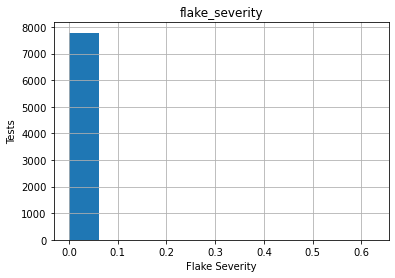

In [10]:
plt.figure(figsize = ((15,10)))
flake_severity.hist()
plt.ylabel("Tests")
plt.xlabel("Flake Severity")
plt.show()

From the above graph we can conclude that most of the tests have very low(~0) flake severity. One might look at this graph and assume that almost all of the tests have flake severity as 0. So, to get more clarity we have plotted another graph and here we've gone from about 8,000 tests to investigate for probable flakiness to less than 100. 

<Figure size 1080x720 with 0 Axes>

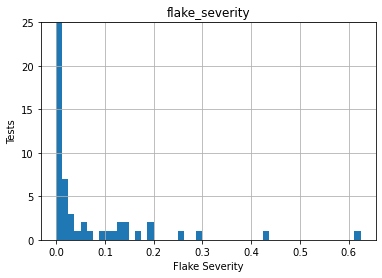

In [11]:
plt.figure(figsize = ((15,10)))
flake_severity.hist(bins=50)
plt.ylabel("Tests")
plt.xlabel("Flake Severity")
plt.ylim((0,25))
plt.show()

From the above graph we can see that there are other values of flake severity for some tests. However it is a small bunch of tests that show a different set of flake severity. Let's see some tests that have a high flake severity score.

The top 5 tests with the highest flake score :

In [12]:
flake_severity.nlargest(5, 'flake_severity')

,test,flake_severity
3376,[sig-arch] Monitor cluster while tests execute,0.624231
3377,[sig-arch] Monitor cluster while tests execute...,0.433333
3819,[sig-network-edge] Application behind service ...,0.291732
3820,[sig-network-edge] Cluster frontend ingress re...,0.257874
3487,[sig-auth][Feature:SCC][Early] should not have...,0.188283


In [13]:
# saving only the first 1 million out of 30 million rows due to pvc limits. Expected data size is 7.5 GB
# 250mb = 1 million --> 7500 mb = 30 million
file = "flakes.csv"
folder = "../../../../data/processed/metrics/percent_flake_by_test"
if not os.path.exists(folder):
    os.makedirs(folder)

fullpath = os.path.join(folder, file)
df_csv.head(1000000).to_csv(fullpath, header=False)

In [14]:
# Send to Ceph - TODO!
# currently waiting on ceph bucket but it will look something like this

In [15]:
# Overall flake percentage
df_csv.head(1000000).flake.sum() / df_csv.head(1000000).flake.count()

0.003037